In [128]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Use the Fourier series for a square wave to generate a wave of a given frequency.

For a square wave, $f(x)=\sum_{k=1}^{\infty}\frac{2}{k\pi}\left(1-(-1)^k\right)\sin{\left(\frac{2k\pi x}{L}\right)}$

In [129]:
fs=10000. # sampling frequency
nsample=1000 # number of samples
# code given by lab script:
"""f1=300. # signal frequency 1
amp1=0.5 # amplitude 1
f2=100. # signal frequency 2
amp2=1 # amplitude 2"""

def sqare_wave(f: float, amp: float, sample_nums: np.ndarray, fourier_terms: int = 4):
    """ Returns a sqare wave with frequency f and amplitude amp, sampled at 
    positions in array sample_nums divided by the sampling frequency.
    fourier_terms is the number of terms in the Fourier series to use
    """
    L = f/fs
    y=0
    for k in range(1,fourier_terms+1):
        y += 2*(1-(-1)**k)/(k*np.pi)*np.sin(2*np.pi*(k)*sample_nums/fs/L)
    
    return amp*y

Generate example signal and plot

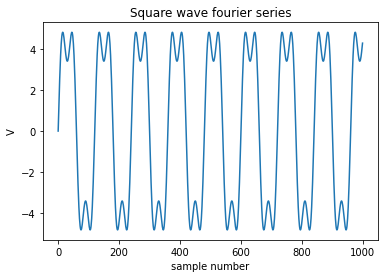

In [130]:
sample_nums = np.arange(nsample) # sample numbers
# plot signal
# code given by lab script:
# signal=amp1*np.sin(2*np.pi*sample_nums*f1/fs)+amp2*np.sin(2*np.pi*sample_nums*f2/fs)
signal = sqare_wave(120,4, sample_nums)
plt.plot(signal)
plt.xlabel('sample number')
plt.ylabel('V')
plt.title("Square wave fourier series")
plt.show()

Get Fourier transform of signal and plot

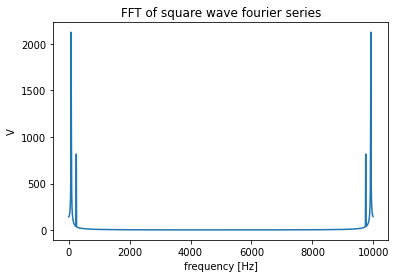

In [131]:
# perform the FFT. Outputs list of complex numbers
fourier=np.fft.fft(signal)
# frequencies for the coefficient from the FFT
ffs=fs/nsample*sample_nums
# plot FFT
plt.plot(ffs,abs(fourier))
plt.xlabel('frequency [Hz]')
plt.ylabel('V')
plt.title("FFT of square wave fourier series")
plt.show()

We also plot the phase. To make the plot look better, we only plot the phases where the amplitude of the FFT is large (since the phases are only meaningful where the FFT amplitude is significant). Elsewhere in the plot we set the phase to 0. Note that the phase is antisymmetric about the Nyquist frequency $f_N = f_s/2$

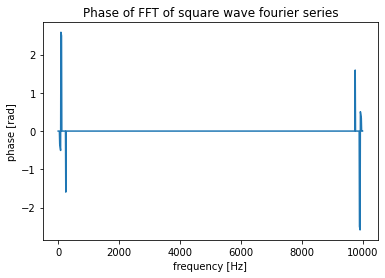

In [132]:
# we also want to plot the phase of the FFT
# we only plot when the amplitude of the FFT coefficient is large
# to avoid plotting noise
min_amplitude = 200
angles = [np.angle(fourier[i]) if abs(fourier[i])>min_amplitude else 0 for i in range(len(fourier)) ]
plt.plot(ffs, angles)
plt.xlabel('frequency [Hz]')
plt.ylabel('phase [rad]')
plt.title("Phase of FFT of square wave fourier series")
plt.show()

Perform inverse FT to get the original signal back

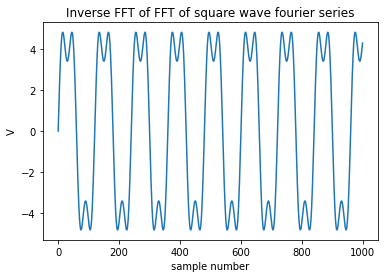

In [133]:
# inverse FFT (use real part because numerical errors will introduce non-zero (but small) imaginary part)
reverse=np.real(np.fft.ifft(fourier))
# plot inverse FFT
plt.plot(reverse)
plt.xlabel('sample number')
plt.ylabel('V')
plt.title("Inverse FFT of FFT of square wave fourier series")
plt.show()

We also plot the inverse of the FFT of the series with the phase set to 0 on all the coefficients (i.e. plotting the FFT of only the magnitude with no imaginary part)

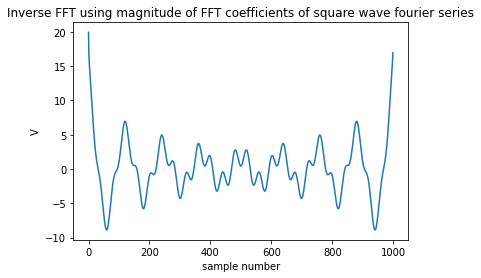

In [134]:
# compute inverse FFT using only magnitude of FFT coefficients (equivalent to setting phase to 0)
reverse_real =np.real(np.fft.ifft(np.abs(fourier)))

# plot inverse FFT
plt.plot(reverse_real)
plt.xlabel('sample number')
plt.ylabel('V')
plt.title("Inverse FFT using magnitude of FFT coefficients of square wave fourier series")
plt.show()

We now zero all frequencies above the Nyquist frequency and do an inverse FFT

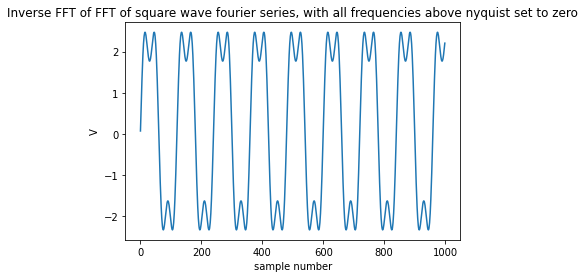

In [135]:
nyquist = fs/2 # nyquist frequency
num_frequencies = nyquist/fs * len(ffs) # number of frequencies in the FFT below the nyquist frequency

# initialise corrected_fourier to be all zeros, then replace all the values below the nyquist frequency with the original values
# we have to specify dtype=complex otherwise it will cast the complex numbers to floats in the next line
corrected_fourier = np.zeros(len(fourier), dtype=complex) 
corrected_fourier[:int(num_frequencies)] = fourier[:int(num_frequencies)]

# do the inverse DFT
corrected_reverse = np.real(np.fft.ifft(corrected_fourier))

# plot the signal
plt.plot(corrected_reverse)
plt.xlabel('sample number')
plt.ylabel('V')
plt.title("Inverse FFT of FFT of square wave fourier series, with all frequencies above nyquist set to zero")
plt.show()
